# Facial recognition via transfer learning

One of the common uses for AI is facial recognition. Transfer learning used with CNNs trained on the ImageNet dataset can do a credible job of recognizing faces in images, but state-of-the-art facial recognition can be achieved by combining transfer learning with CNNs trained with millions of facial images. Fortunately, a handful of such pretrained CNNs exist and are available in the public domain. Let's use Keras to train a pair of facial recognition models — one that uses `ResNet50` initialized with ImageNet weights, and another that uses `ResNet50` initialized with weights optimized for facial recognition — and see just how accurate CNN-based facial recognition can be. We'll use the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) dataset to train and validate the networks.

![](Images/lfw-color.png)

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

Unlike in previous examples in which we loaded 47x62 grayscale images from the LFW dataset, this time we will load 128x128 color images. CNNs work better with images that have equal widths and heights, and pretrained CNNs such as `ResNet50` are designed to work with 3-channel color images.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder']
(760, 128, 128, 3)


Use the following code to show the first several images in the dataset and the people to whom the faces belong.

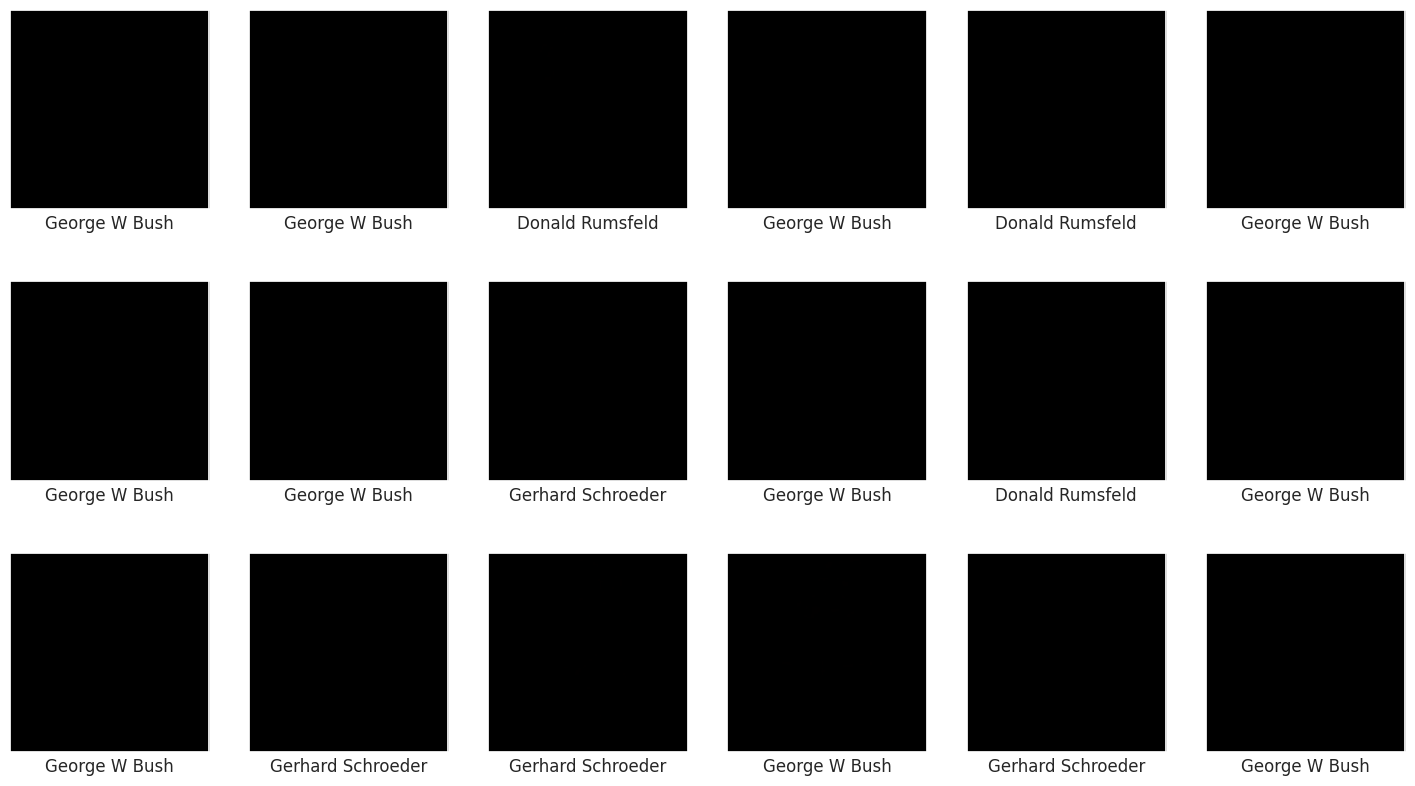

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each of the five persons, or classes, that the CNN will try to predict.

<Axes: >

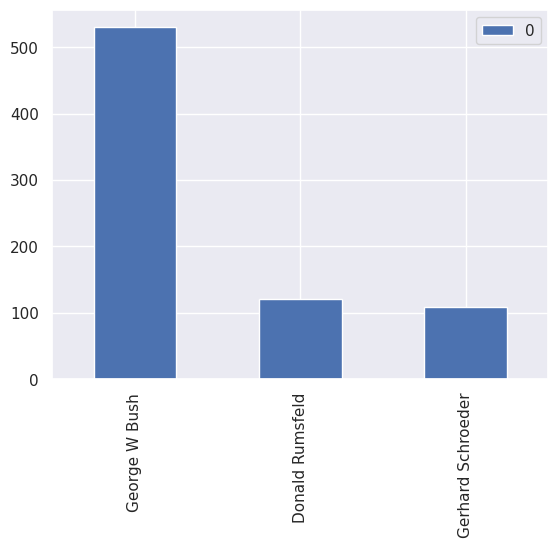

In [3]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

Classification models are best trained with balanced datasets. Use the following code to build a dataset containing 100 images of each person.

In [5]:
# Create a mask for selecting samples
mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    target_indices = np.where(faces.target == target)[0]
    mask[target_indices[:min(100, len(target_indices))]] = True

# Apply the mask to select data
x_faces = faces.data[mask]
y_faces = faces.target[mask]

# Reshape the data
x_faces = x_faces.reshape(-1, *faces.images[0].shape)
x_faces.shape

(300, 128, 128, 3)

The next step is to preprocess pixel values the way `ResNet50` expects and convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) them. Then split the data for training and testing.

In [24]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0, shuffle=True)

## Use transfer learning with `ResNet50` and ImageNet weights

The first model we'll build employs transfer learning with `ResNet50` intialized with the weights computed when the network was trained on more than 1 million images from the ImageNet dataset. Start by loading `ResNet50` without the classification layers and freezing the bottleneck layers.

In [25]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

Now add classification layers to the base model and include a `Resizing` layer to resize images input to the network to 224x224.

In [26]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Call `fit` to train the model.

In [29]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=35)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7497 - loss: 0.5355 - val_accuracy: 0.6333 - val_loss: 0.6887
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7871 - loss: 0.5478 - val_accuracy: 0.6167 - val_loss: 0.6204
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7485 - loss: 0.5358 - val_accuracy: 0.7667 - val_loss: 0.5624
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8759 - loss: 0.4315 - val_accuracy: 0.8000 - val_loss: 0.5445
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8508 - loss: 0.4305 - val_accuracy: 0.7333 - val_loss: 0.6419
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8424 - loss: 0.4918 - val_accuracy: 0.8000 - val_loss: 0.5312
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8245 - loss: 0.5162 - val_accuracy: 0.7500 - val_loss: 0.6299
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7440 - loss: 0.5450 - val_accuracy: 0.8667 - val_loss: 0.5110
Epoch 9/

Plot the training and validation accuracy to see how well the network performed.

[]

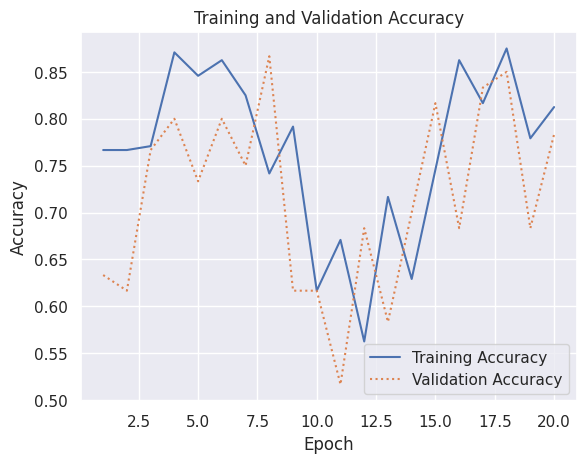

In [30]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run some test data through the network and use a confusion matrix to see how it fared.

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


Text(109.44999999999996, 0.5, 'Actual label')

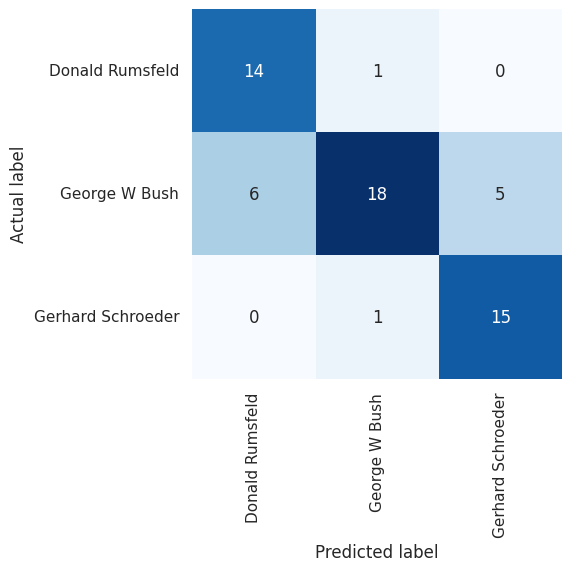

In [31]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

How many times did the network correctly identify George W. Bush? How many times did it fail to identify him?

## Use transfer learning with `ResNet50` and VGGFace2 weights

Initialized with ImageNet weights, `ResNet50` achieves about 90% accuracy recognizing faces in the LFW dataset. But the ImageNet weights were generated by training the network with images of hundreds of different objects ranging from butterflies to basketballs. These weights are not optimized for extracting features from faces.

[keras-vggface](https://pypi.org/project/keras-vggface/) is a Python package that models pretrained CNNs trained to recognize the faces of famous people. These CNNs (and their weights) are encapsulated in a class named `VGGFace`. Let's load the bottleneck layers of the `ResNet50` version of `VGGFace` along with the weights arrived at when it was trained with more than 3 million images in the [VGGFace2](https://arxiv.org/abs/1710.08092) dataset and use transfer learning to train the resulting network on the LFW dataset. Begin by loading `VGGFace` without the classification layers and freezing the bottleneck layers.

In [38]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Convert face images to TensorFlow tensors
face_images = tf.convert_to_tensor(x_faces, dtype=tf.float32)

# Preprocess images using ResNet50's preprocessing
face_images = preprocess_input(face_images)

# Convert labels to categorical
face_labels = to_categorical(y_faces)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    face_images.numpy(),  # Convert back to numpy for sklearn
    face_labels,
    train_size=0.4,
    stratify=face_labels,
    random_state=42,
    shuffle=True
)

# Convert split datasets back to tensors
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

# Create the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# If your input shape is different, you may need to add a resizing layer
# input_layer = tf.keras.layers.Input(shape=(your_height, your_width, 3))
# resized_images = tf.keras.layers.Resizing(224, 224)(input_layer)
# x = base_model(resized_images)

Add classification layers to the base model and include a `Resizing` layer to resize images input to the network to 224x224.

In [39]:
model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Call `fit` to train the model.

In [40]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.3042 - loss: 22.3728 - val_accuracy: 0.3333 - val_loss: 10.8987
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.2907 - loss: 6.8670 - val_accuracy: 0.3611 - val_loss: 1.1055
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4458 - loss: 1.2916 - val_accuracy: 0.5389 - val_loss: 0.9438
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5188 - loss: 1.1187 - val_accuracy: 0.3389 - val_loss: 1.2101
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4191 - loss: 1.0214 - val_accuracy: 0.3889 - val_loss: 0.9839
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5548 - loss: 1.1120 - val_accuracy: 0.3333 - val_loss: 2.1143
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.3467 - loss: 1.6161 - val_accuracy: 0.4611 - val_loss: 1.0996
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5317 - loss: 0.9189 - val_accuracy: 0.5056 - val_los

Plot the training and validation accuracy to see how well the network performed.

[]

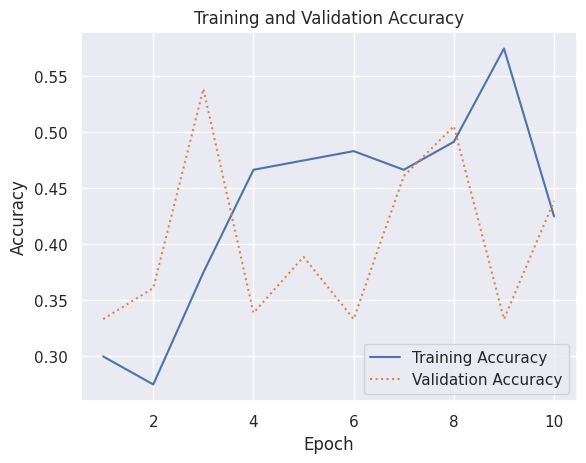

In [41]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run some test data through the network and use a confusion matrix to see how it fared.

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


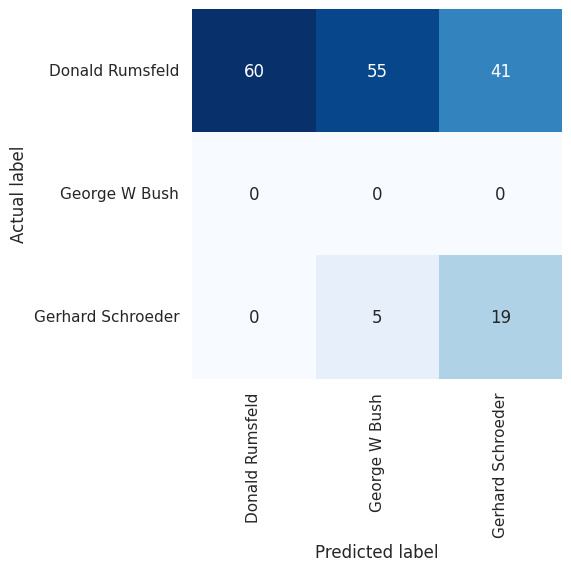

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the labels for the test set
y_predicted = model.predict(x_test)

# Convert TensorFlow tensor to NumPy array
y_test_np = y_test.numpy()

# Compute the confusion matrix
mat = confusion_matrix(y_test_np.argmax(axis=1), y_predicted.argmax(axis=1))

# Plot the confusion matrix using a heatmap
sns.heatmap(mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=False, 
            cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

# Label the axes
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# Display the plot
plt.show()


Loaded with weights optimized for extracting features from faces, `ResNet50` is *much* better at recognizing faces than the same network initialized with ImageNet weights. One of the lessons here is that transfer learning using task-specific weights is typically better than transfer learning using generic weights.

## Make a prediction

Load a picture of George W. Bush downloaded from the Internet that has been cropped to 128x128 and use it to make a prediction. The first step is to load the image.

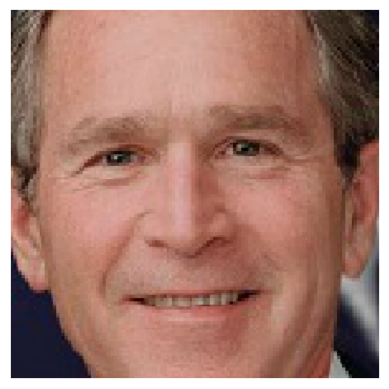

In [45]:
from keras.preprocessing import image

x = image.load_img('Data/george.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Now see if the network can identify the person in the picture.

In [46]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
y = model.predict(x)[0]

for i in range(len(y)):
    print(faces.target_names[i] + ': ' + str(y[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Donald Rumsfeld: 0.99646795
George W Bush: 0.0007451987
Gerhard Schroeder: 0.0027868398


Did it correctly identify the face as that of George W. Bush? How confident was it in its prediction?